<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задачи" data-toc-modified-id="Задачи-1">Задачи</a></span></li><li><span><a href="#Подключение-к-базе-данных" data-toc-modified-id="Подключение-к-базе-данных-2">Подключение к базе данных</a></span></li><li><span><a href="#Структура-схемы" data-toc-modified-id="Структура-схемы-3">Структура схемы</a></span></li><li><span><a href="#Profiles" data-toc-modified-id="Profiles-4">Profiles</a></span></li><li><span><a href="#Orders" data-toc-modified-id="Orders-5">Orders</a></span></li><li><span><a href="#Costs" data-toc-modified-id="Costs-6">Costs</a></span></li><li><span><a href="#Sessions" data-toc-modified-id="Sessions-7">Sessions</a></span></li><li><span><a href="#Разведочный-анализ" data-toc-modified-id="Разведочный-анализ-8">Разведочный анализ</a></span><ul class="toc-item"><li><span><a href="#Период-времени" data-toc-modified-id="Период-времени-8.1">Период времени</a></span></li><li><span><a href="#Количество-пользователей-и-%-платящих-пользователей" data-toc-modified-id="Количество-пользователей-и-%-платящих-пользователей-8.2">Количество пользователей и % платящих пользователей</a></span></li></ul></li><li><span><a href="#Когортный-анализ" data-toc-modified-id="Когортный-анализ-9">Когортный анализ</a></span><ul class="toc-item"><li><span><a href="#Конверсия-по-когортам" data-toc-modified-id="Конверсия-по-когортам-9.1">Конверсия по когортам</a></span></li><li><span><a href="#Retention-Rate-по-когортам" data-toc-modified-id="Retention-Rate-по-когортам-9.2">Retention Rate по когортам</a></span></li></ul></li></ul></div>

# Когортный анализ онлайн магазина с помощью SQL

С помощью postgreSQL провести когортный анализ данных онлайн магазина

## Задачи

- Рассчитать коэффициент конверсии в первую покупку по когортам
- Рассчитать коэффициент удержания пользователей по когортам

## Подключение к базе данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import seaborn as sns

pd.options.display.max_rows = 100

In [2]:
db_config = {
    'user': 'postgres', # имя пользователя
    'pwd': 'postgres', # пароль
    'host': 'localhost',
    'port': 5432, # порт подключения
    'db': 'postgres' # название базы данных
}

In [3]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
engine = create_engine(connection_string) 

In [5]:
def select(q):
    return pd.read_sql_query(q, con=engine)

## Структура схемы

Посмотрим какие таблицы содержаться в схеме `online_store`

In [6]:
query = """
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'online_store'
"""

select(query)

,table_name
0,costs
1,events
2,orders
3,profiles
4,sessions


Схема содержит 5 таблиц:
- `costs` - затраты на привлечение пользователей
- `events` - события в приложении
- `orders` - заказы, оформленные клиентами
- `profiles` - профили зарегистрированных пользователей
- `sessions` - информация о сессиях пользователей

## Profiles

In [7]:
query = """
    SELECT *
    FROM online_store.profiles
    LIMIT 5;
"""

select(query)

,user_id,first_ts,channel,device,region,dt,month,payer
0,10964006,2020-06-25 04:50:17,Yandex,Mac,Germany,2020-06-25,2020-06-01,True
1,12358165,2020-06-23 23:16:24,Yandex,iPhone,United States,2020-06-23,2020-06-01,False
2,12545358,2020-06-18 19:22:46,Organic,Mac,United States,2020-06-18,2020-06-01,False
3,16165560,2020-06-23 20:29:59,Yandex,PC,United States,2020-06-23,2020-06-01,False
4,17733464,2020-06-25 11:08:25,Organic,iPhone,France,2020-06-25,2020-06-01,True


## Orders

In [8]:
query = """
    SELECT *
    FROM online_store.orders
    LIMIT 5;
"""

select(query)

,user_id,event_dt,revenue
0,55519067947,2020-06-14,5.62
1,831753022495,2020-06-14,1.33
2,284598472478,2020-06-14,4.93
3,725363192554,2020-06-14,1.55
4,324356134597,2020-06-14,9.60


## Costs

In [9]:
query = """
    SELECT *
    FROM online_store.costs
    LIMIT 5;
"""

select(query)

,dt,channel,costs
0,2020-06-14,AnotherSource,1826.0
1,2020-06-15,AnotherSource,1443.0
2,2020-06-16,AnotherSource,1508.0
3,2020-06-17,AnotherSource,1911.0
4,2020-06-18,AnotherSource,1837.0


## Sessions

In [10]:
query = """
    SELECT *
    FROM online_store.sessions
    LIMIT 5;
"""

select(query)

,user_id,region,device,channel,session_duration,session_start
0,94834909438,Germany,iPhone,Yandex,5.0,2020-06-14 12:59:48
1,142292250445,United States,iPhone,Organic,33.0,2020-06-14 21:25:00
2,486879489291,United States,Mac,Organic,34.0,2020-06-14 21:18:40
3,996478278264,Germany,iPhone,Yandex,77.0,2020-06-14 07:37:52
4,857023407503,United States,Android,Organic,6.0,2020-06-14 01:35:01


## Разведочный анализ

### Период времени

Посмотрим, каким периодом времени в данных мы распологаем

In [11]:
query = """
    SELECT 
        min(event_dt), 
        max(event_dt), 
        max(event_dt) - min(event_dt) AS days
    FROM online_store.orders
"""

select(query)

,min,max,days
0,2020-06-14,2020-06-27,13


Всего 13 дней с момента запуска продаж в приложении

### Количество пользователей и % платящих пользователей

Посмотрим общее количество уникальных пользователей

In [12]:
query = """
    SELECT count(*)
    FROM online_store.profiles
"""

select(query)

,count
0,141345


Из них не платящих и платящих

In [13]:
query = """
    SELECT payer, count(*)
    FROM online_store.profiles
    GROUP BY payer
"""

select(query)

,payer,count
0,False,128283
1,True,13062


Платящих в %

In [14]:
query = """
    WITH
    clients AS (SELECT count(*) AS clients
                FROM online_store.profiles
                WHERE payer = True),
    users AS (SELECT count(*) AS users
              FROM online_store.profiles)
    SELECT (clients * 100.0) / users AS cr1
    FROM clients, users
"""

select(query)

,cr1
0,9.241218


9.24% платящих пользователей или конверсия пользователя в первую покупку (C1)

## Когортный анализ

В качестве когорт у нас будут даты регистрации

### Конверсия по когортам

In [15]:
query = """
    WITH
    cohort_size AS (SELECT dt, count(user_id) AS cohort_size
                    FROM online_store.profiles p
                    GROUP BY dt),
    
    fp AS (SELECT user_id, min(event_dt) AS first_purchase_dt
           FROM online_store.orders o
           GROUP BY user_id),
           
    p AS (SELECT 
            p.user_id,
            dt,
            EXTRACT(DAY FROM first_purchase_dt - first_ts) AS lifetime
          FROM online_store.profiles p
          LEFT JOIN fp ON fp.user_id = p.user_id),
    
    res AS (SELECT 
              p.dt, 
              lifetime, 
              cohort_size, 
              count(user_id) AS clients,
              (count(user_id) * 100.0) / cohort_size AS cr
           FROM p
           LEFT JOIN cohort_size cs ON cs.dt = p.dt
           GROUP BY p.dt, lifetime, cohort_size
           HAVING lifetime IS NOT NULL
           ORDER BY p.dt)
           
    SELECT 
        *, 
        sum(cr) over(partition by dt order by lifetime) AS cum_cr
    FROM res
"""

cr1 = select(query)

In [16]:
cr1.head()

,dt,lifetime,cohort_size,clients,cr,cum_cr
0,2020-06-14,0.0,10369,724,6.982351,6.982351
1,2020-06-14,1.0,10369,87,0.839039,7.821391
2,2020-06-14,2.0,10369,55,0.530427,8.351818
3,2020-06-14,3.0,10369,31,0.298968,8.650786
4,2020-06-14,4.0,10369,33,0.318256,8.969042


In [17]:
cr1_pivot = cr1.pivot(index='dt', columns='lifetime', values='cum_cr').round(2)

In [18]:
cr1_pivot

lifetime,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
dt,,,,,,,,,,,,,
2020-06-14,6.98,7.82,8.35,8.65,8.97,9.21,9.36,9.49,9.67,9.73,9.82,9.87,9.96
2020-06-15,7.36,8.33,8.99,9.32,9.61,9.81,10.02,10.24,10.38,10.43,10.57,10.62,NaN
2020-06-16,8.48,9.07,9.39,9.55,9.74,9.85,9.96,10.01,10.06,10.15,10.18,NaN,NaN
2020-06-17,9.27,9.82,10.14,10.31,10.47,10.56,10.66,10.75,10.83,10.90,NaN,NaN,NaN
2020-06-18,9.46,9.85,10.12,10.27,10.40,10.47,10.51,10.53,10.58,NaN,NaN,NaN,NaN
2020-06-19,7.78,8.48,8.85,9.11,9.39,9.51,9.62,9.77,NaN,NaN,NaN,NaN,NaN
2020-06-20,7.49,7.94,8.34,8.55,8.81,9.06,9.16,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-21,7.34,8.04,8.53,8.80,9.03,9.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-22,7.63,8.39,8.99,9.39,9.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


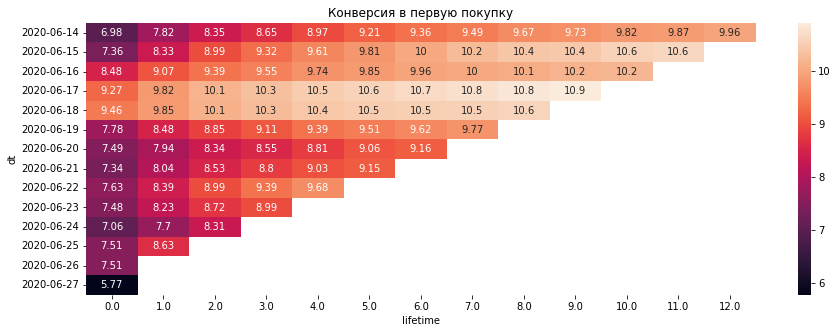

In [19]:
plt.figure(figsize=(15, 5))
sns.heatmap(cr1_pivot, annot=True, fmt='.3g')
plt.title('Конверсия в первую покупку')
plt.show()

### Retention Rate по когортам

In [20]:
query = """
    SELECT event_dt, count(distinct user_id)
    FROM online_store.orders o
    GROUP BY event_dt
"""

select(query)

,event_dt,count
0,2020-06-14,570
1,2020-06-15,796
2,2020-06-16,1224
3,2020-06-17,1575
4,2020-06-18,1717
5,2020-06-19,1501
6,2020-06-20,1507
7,2020-06-21,1383
8,2020-06-22,1408
9,2020-06-23,1630


In [21]:
query = """
    WITH
    p AS (SELECT 
             user_id, 
             dt, 
             COUNT(*) OVER (PARTITION BY dt) AS cohort_size
           FROM online_store.profiles p),

    s AS (SELECT 
             user_id,
             session_start::date AS session_date
          FROM online_store.sessions s
          GROUP BY 1,2)
        
    SELECT 
        dt, 
        session_date - dt AS lifetime,
        cohort_size,
        (count(p.user_id) * 100.0) / cohort_size AS retention
    FROM p
    JOIN s ON p.user_id = s.user_id
    GROUP BY 1, 2, 3
    ORDER BY 1
"""

retention = select(query)

In [22]:
retention.head()

,dt,lifetime,cohort_size,retention
0,2020-06-14,0,10369,100.000000
1,2020-06-14,1,10369,51.914360
2,2020-06-14,2,10369,35.210724
3,2020-06-14,3,10369,27.051789
4,2020-06-14,4,10369,21.246022


In [23]:
retention_pivot = retention.pivot(index='dt', columns='lifetime', values='retention').round(2)

In [24]:
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,
2020-06-14,100.0,51.91,35.21,27.05,21.25,18.43,15.74,14.93,12.79,11.48,10.37,9.56,8.61,8.05
2020-06-15,100.0,50.65,36.16,26.98,22.48,18.77,15.42,13.80,12.41,11.13,9.96,10.12,9.36,NaN
2020-06-16,100.0,26.95,13.06,7.37,4.87,3.41,2.99,2.24,1.81,1.56,1.19,1.10,NaN,NaN
2020-06-17,100.0,26.65,12.94,7.79,4.89,3.38,2.69,2.08,2.05,1.48,1.21,NaN,NaN,NaN
2020-06-18,100.0,19.00,7.66,4.17,2.21,1.69,1.27,0.81,0.65,0.55,NaN,NaN,NaN,NaN
2020-06-19,100.0,33.24,17.19,11.31,8.24,6.33,4.62,4.06,3.33,NaN,NaN,NaN,NaN,NaN
2020-06-20,100.0,32.54,17.49,11.68,7.87,6.46,4.43,4.20,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-21,100.0,38.46,23.06,15.64,11.91,8.92,7.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-22,100.0,47.71,31.63,23.33,18.09,15.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отбросим нулевой лайфтайм и потсроим тепловую карту

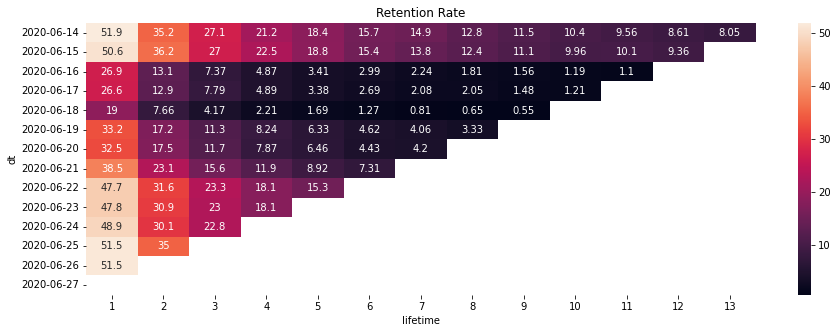

In [25]:
plt.figure(figsize=(15, 5))
sns.heatmap(retention_pivot.iloc[::, 1:], annot=True, fmt='.3g')
plt.title('Retention Rate')
plt.show()